#  Project 3 Part 2

*  **Nicholas Giuffrida**

* **For *Theft* and *Battery*, perform the following steps to develop a forecast.**

  - Transform the data to obtain a time series of the crime count per month using .size().
  - Check for and address null values.
  - Decompose the Time series to detect seasonality and decide whether to use a seasonal model or not
  - Determine if nonseasonal and/or seasonal differencing is required
  - Use the ACF and PACF plots of stationarity data to estimate initial orders
  - Split the time series into training and test data (Remember we want to predict 6 months)
  - Fit a manual ARIMA/SARIMA model based on the orders determined during your exploration.
   - Make forecasts with your model.
   - Plot the forecasts versus the test data
   - Obtain metrics for evaluation
 - Tune with pmdarima's auto_arima
   - Fit a model on training data with the best parameters from auto_arima
   - Obtain metrics for evaluation
   - Make forecasts with the auto_arima model
   - Plot the forecasts versus the test data
 - Select the final model and justify your choice. (Which metrics or diagnostics support your choice?)
 - Make true future forecasts using the entire dataset (for dates beyond the entire ts)
* **For each crime, answer the following questions in a markdown cell:**

 - Calculate the predicted net change in the number (raw counts) of this type of crime from the beginning of the forecast to the end.
 - Convert the raw delta into a percent change.
* **Final Evaluation:**

 -  After completing both models and getting the forecasts for both crimes for 6 months into the future (beyond the data), answer the following questions in a Markdown cell:

   - Of the two crimes, which is forecasted to have the highest monthly count of crimes at the end of the forecast?
Of the two crimes, which is forecasted to have the highest net change by the end of the forecast?
   - Of the two crimes, which is forecasted to have the highest percent change by the end of the forecast?
* **Final Recommendations**

 - What recommendation would you make to the stakeholders?
 - Include reporting-quality visual(s) to support your recommendation.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs
from pmdarima.model_selection import train_test_split
import pmdarima as pm
plt.rcParams['figure.figsize']=(12,3)
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn import set_config
import os
import itertools
set_config(transform_output="pandas")
plt.rcParams["figure.figsize"] = (12, 5)
sns.set_context("poster", font_scale=0.9)

##  Custom Functions

In [2]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs):
    # Save each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [3]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black', method = 'ywm'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)  
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)    
    # Annotate sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    # seasons
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        # Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        # for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

In [4]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    # PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)
    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)
    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")
    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [5]:
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [6]:
# Load Data
fname ="Data/Crime_time.csv"
df = pd.read_csv(fname)

In [7]:
df.head()

,Date,Primary Type,District,Crime,True,Month,Year
0,2001-01-01 00:00:00,SEX OFFENSE,10,ID,9754953,1,2001
1,2001-01-01 00:00:00,CRIM SEXUAL ASSAULT,2,ID,3994567,1,2001
2,2001-01-01 00:00:00,THEFT,8,ID,1927872,1,2001
3,2001-01-01 00:00:00,OFFENSE INVOLVING CHILDREN,2,ID,4768442,1,2001
4,2001-01-01 00:00:00,THEFT,9,ID,2280620,1,2001


In [8]:

df['Date'] = pd.to_datetime(df['Date'])
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7713062 entries, 0 to 7713061
Data columns (total 7 columns):
 #   Column        Dtype         
---  ------        -----         
 0   Date          datetime64[ns]
 1   Primary Type  object        
 2   District      int64         
 3   Crime         object        
 4   True          int64         
 5   Month         int64         
 6   Year          int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 411.9+ MB


,Date,Primary Type,District,Crime,True,Month,Year
0,2001-01-01,SEX OFFENSE,10,ID,9754953,1,2001
1,2001-01-01,CRIM SEXUAL ASSAULT,2,ID,3994567,1,2001
2,2001-01-01,THEFT,8,ID,1927872,1,2001


In [9]:
df = df.set_index("Date")
df

,Primary Type,District,Crime,True,Month,Year
Date,,,,,,
2001-01-01 00:00:00,SEX OFFENSE,10,ID,9754953,1,2001
2001-01-01 00:00:00,CRIM SEXUAL ASSAULT,2,ID,3994567,1,2001
2001-01-01 00:00:00,THEFT,8,ID,1927872,1,2001
2001-01-01 00:00:00,OFFENSE INVOLVING CHILDREN,2,ID,4768442,1,2001
2001-01-01 00:00:00,THEFT,9,ID,2280620,1,2001
...,...,...,...,...,...,...
2022-12-31 23:47:00,ASSAULT,22,ID,12938351,12,2022
2022-12-31 23:47:00,WEAPONS VIOLATION,22,ID,12938340,12,2022
2022-12-31 23:50:00,BATTERY,15,ID,12938426,12,2022


In [10]:
df_ts = df.groupby('Primary Type').resample("M").size()
df_ts

Primary Type       Date      
ARSON              2001-01-31     67
                   2001-02-28     57
                   2001-03-31     93
                   2001-04-30     89
                   2001-05-31     94
                                ... 
WEAPONS VIOLATION  2022-08-31    832
                   2022-09-30    780
                   2022-10-31    735
                   2022-11-30    597
                   2022-12-31    543
Length: 8602, dtype: int64

In [11]:
df_ts.head().index

MultiIndex([('ARSON', '2001-01-31'),
            ('ARSON', '2001-02-28'),
            ('ARSON', '2001-03-31'),
            ('ARSON', '2001-04-30'),
            ('ARSON', '2001-05-31')],
           names=['Primary Type', 'Date'])

In [12]:
# level 0 is Primary Type
df_ts.index.get_level_values(0)

Index(['ARSON', 'ARSON', 'ARSON', 'ARSON', 'ARSON', 'ARSON', 'ARSON', 'ARSON',
       'ARSON', 'ARSON',
       ...
       'WEAPONS VIOLATION', 'WEAPONS VIOLATION', 'WEAPONS VIOLATION',
       'WEAPONS VIOLATION', 'WEAPONS VIOLATION', 'WEAPONS VIOLATION',
       'WEAPONS VIOLATION', 'WEAPONS VIOLATION', 'WEAPONS VIOLATION',
       'WEAPONS VIOLATION'],
      dtype='object', name='Primary Type', length=8602)

In [13]:
# Level 1 is DATE
df_ts.index.get_level_values(1)

DatetimeIndex(['2001-01-31', '2001-02-28', '2001-03-31', '2001-04-30',
               '2001-05-31', '2001-06-30', '2001-07-31', '2001-08-31',
               '2001-09-30', '2001-10-31',
               ...
               '2022-03-31', '2022-04-30', '2022-05-31', '2022-06-30',
               '2022-07-31', '2022-08-31', '2022-09-30', '2022-10-31',
               '2022-11-30', '2022-12-31'],
              dtype='datetime64[ns]', name='Date', length=8602, freq=None)

In [14]:
unstacked = df_ts.unstack(level=0)
unstacked

Primary Type,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,CRIMINAL SEXUAL ASSAULT,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,...,OTHER OFFENSE,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,RITUALISM,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION
Date,,,,,,,,,,,,,,,,,,,,,
2001-01-31,67.0,2123.0,6527.0,1934.0,NaN,162.0,3966.0,3.0,1192.0,1398.0,...,2800.0,563.0,NaN,161.0,2.0,1396.0,218.0,26.0,7867.0,337.0
2001-02-28,57.0,2029.0,6042.0,1666.0,NaN,134.0,3665.0,1.0,1063.0,1163.0,...,2488.0,426.0,1.0,173.0,0.0,1159.0,149.0,13.0,6669.0,301.0
2001-03-31,93.0,2824.0,7662.0,1832.0,NaN,149.0,4617.0,4.0,1141.0,1313.0,...,2836.0,550.0,0.0,267.0,2.0,1399.0,184.0,17.0,7766.0,345.0
2001-04-30,89.0,2746.0,8328.0,1932.0,NaN,132.0,4922.0,2.0,1133.0,1199.0,...,2483.0,564.0,1.0,229.0,1.0,1341.0,169.0,29.0,7702.0,321.0
2001-05-31,94.0,2903.0,8887.0,1997.0,1.0,155.0,4757.0,2.0,1067.0,1261.0,...,2528.0,503.0,1.0,239.0,1.0,1491.0,227.0,12.0,8420.0,390.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,40.0,1984.0,3740.0,674.0,15.0,NaN,2713.0,145.0,392.0,1432.0,...,1214.0,23.0,1.0,56.0,NaN,749.0,127.0,48.0,5244.0,832.0
2022-09-30,49.0,1891.0,3723.0,653.0,13.0,NaN,2619.0,144.0,378.0,1540.0,...,1147.0,59.0,1.0,66.0,NaN,868.0,116.0,33.0,5117.0,780.0
2022-10-31,41.0,1839.0,3501.0,688.0,10.0,NaN,2834.0,162.0,374.0,1568.0,...,1166.0,26.0,1.0,72.0,NaN,945.0,91.0,46.0,5242.0,735.0


In [15]:
unstacked.columns

Index(['ARSON', 'ASSAULT', 'BATTERY', 'BURGLARY',
       'CONCEALED CARRY LICENSE VIOLATION', 'CRIM SEXUAL ASSAULT',
       'CRIMINAL DAMAGE', 'CRIMINAL SEXUAL ASSAULT', 'CRIMINAL TRESPASS',
       'DECEPTIVE PRACTICE', 'DOMESTIC VIOLENCE', 'GAMBLING', 'HOMICIDE',
       'HUMAN TRAFFICKING', 'INTERFERENCE WITH PUBLIC OFFICER', 'INTIMIDATION',
       'KIDNAPPING', 'LIQUOR LAW VIOLATION', 'MOTOR VEHICLE THEFT',
       'NARCOTICS', 'NON - CRIMINAL', 'NON-CRIMINAL',
       'NON-CRIMINAL (SUBJECT SPECIFIED)', 'OBSCENITY',
       'OFFENSE INVOLVING CHILDREN', 'OTHER NARCOTIC VIOLATION',
       'OTHER OFFENSE', 'PROSTITUTION', 'PUBLIC INDECENCY',
       'PUBLIC PEACE VIOLATION', 'RITUALISM', 'ROBBERY', 'SEX OFFENSE',
       'STALKING', 'THEFT', 'WEAPONS VIOLATION'],
      dtype='object', name='Primary Type')

### Theft

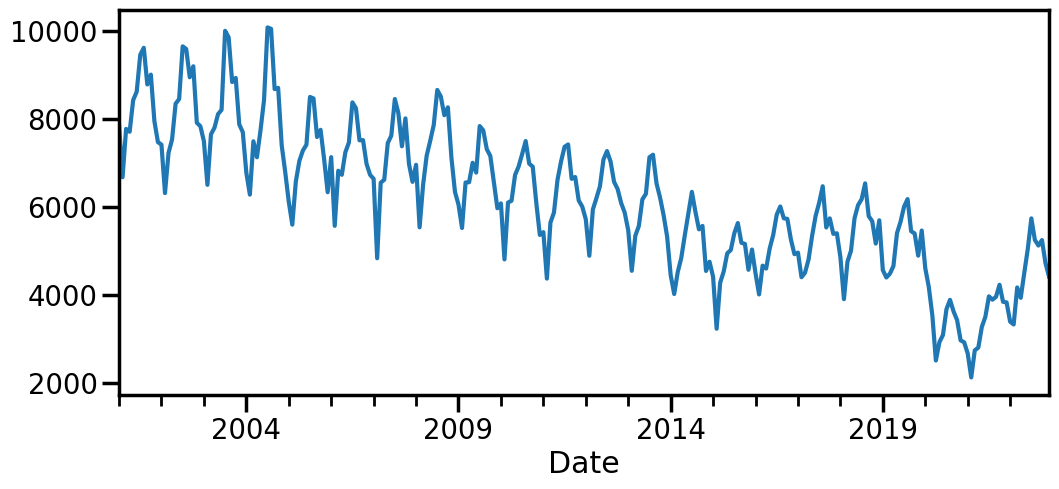

In [16]:
ts_t = unstacked['THEFT']
ax = ts_t.plot()

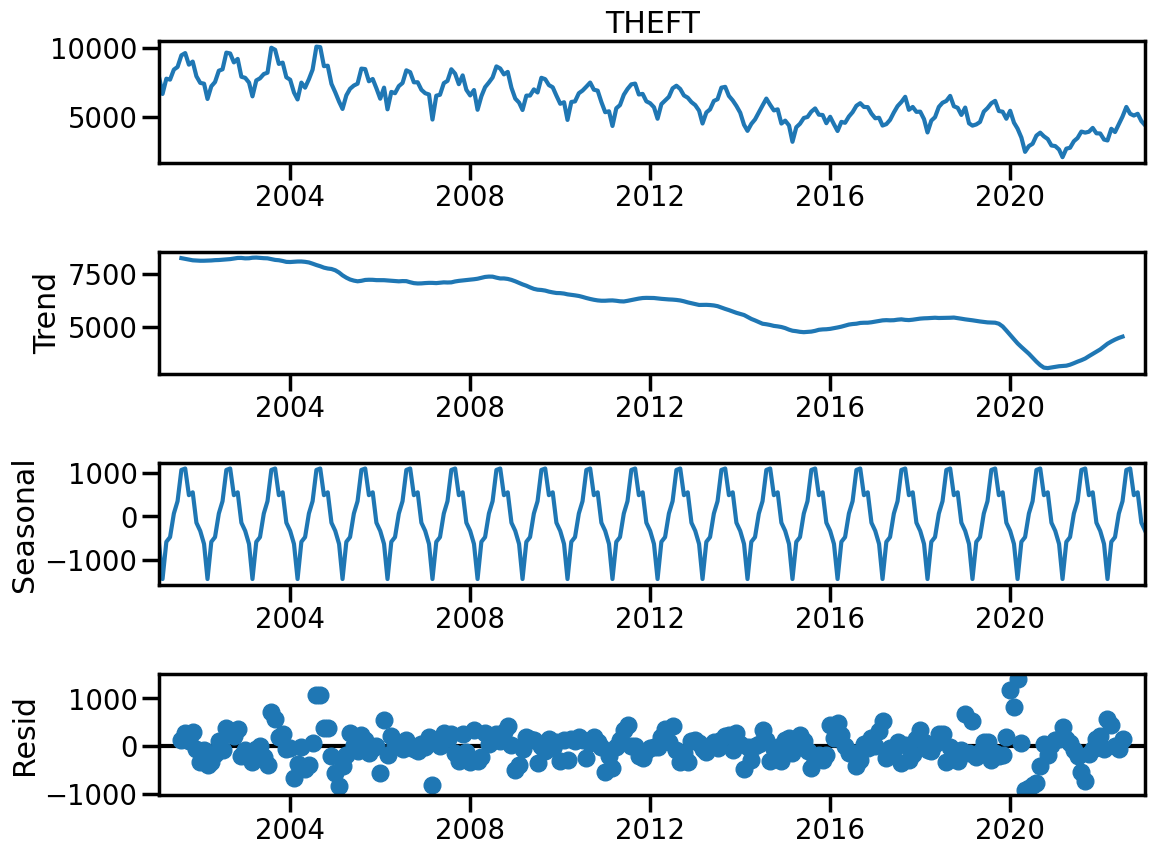

In [17]:
# Apply seasonal decomposition
decomp_t = tsa.seasonal_decompose(ts_t)
fig = decomp_t.plot()
fig.set_size_inches(12,9)
fig.tight_layout()

In [18]:
# Measure seasonal component
seasonal_delta_t = decomp_t.seasonal.max() - decomp_t.seasonal.min()

# Measure seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta_t} which is ~{seasonal_delta_t/float(ts_t.max()-ts_t.min()) * 100 :.2f}% of the variation in time series.")

The seasonal component is 2549.9880952380945 which is ~32.08% of the variation in time series.


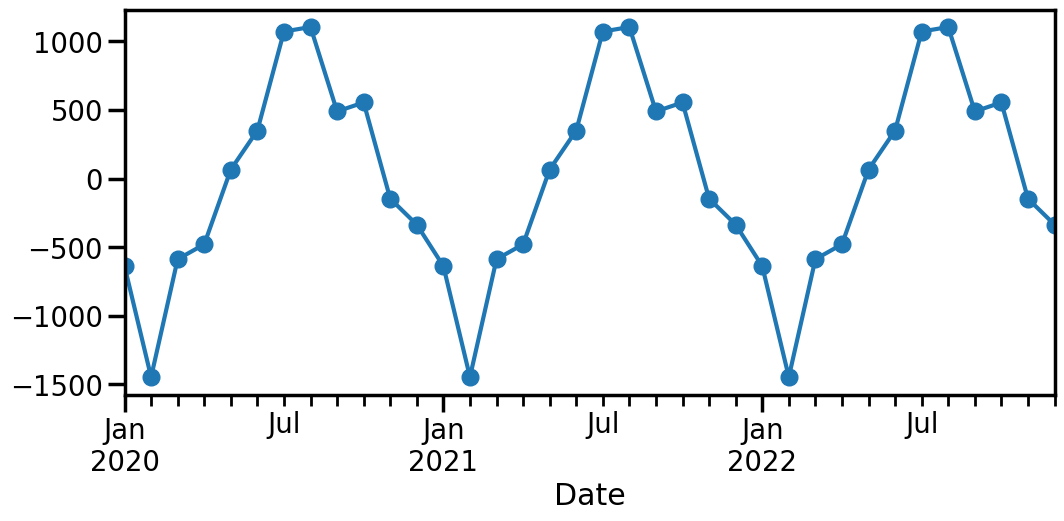

In [21]:
# Narrow down the date range of the plot
seasonal_t = decomp_t.seasonal
ax = seasonal_t.loc['2020': ].plot(marker = 'o')

In [22]:
# determine d
d = ndiffs(ts_t)
print (f'd = {d}')

d = 1


In [23]:
# Determine D
D = nsdiffs(ts_t, m =12)
print(f'D = {D}')

D = 0


In [24]:
# Difference the data
ts_diff_t = ts_t.diff().dropna()

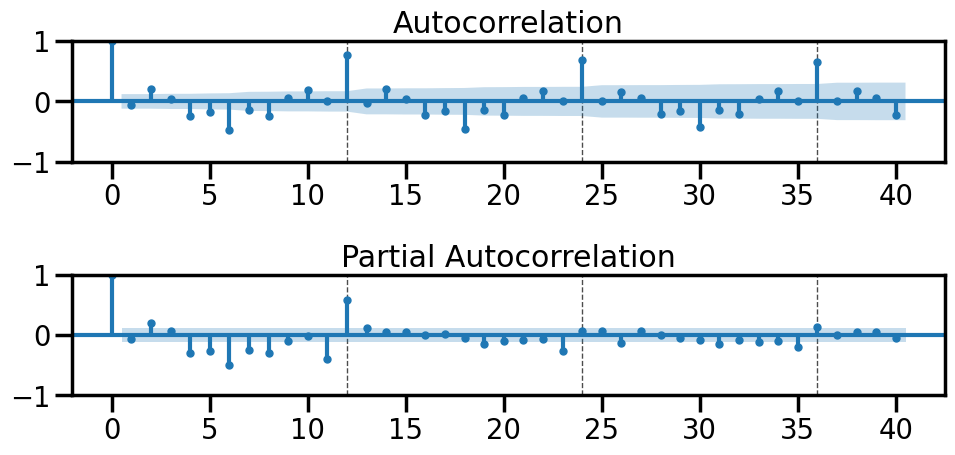

In [62]:
# Use function to highlight the seasonal lags by adding the arguments
plot_acf_pacf(ts_diff_t, annotate_seas=True, m = 12, method = 'ywm');

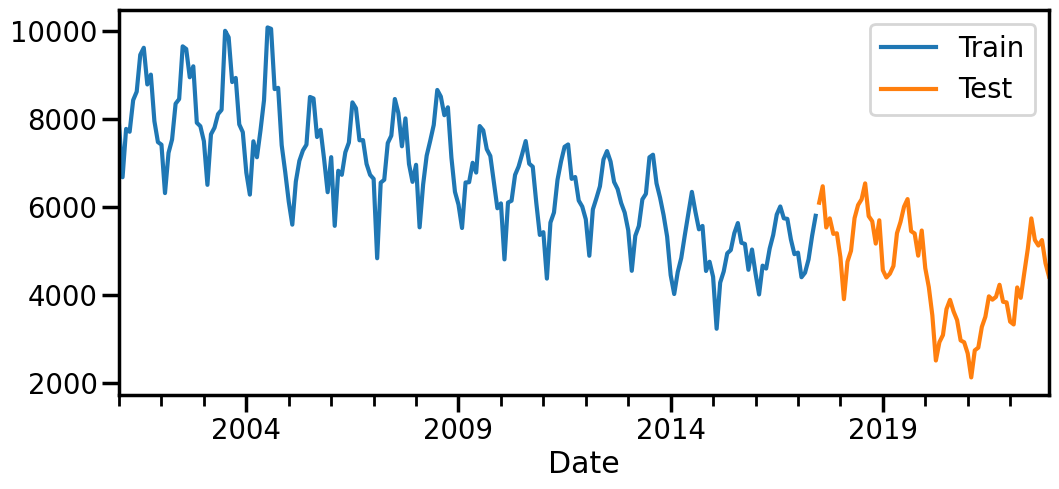

In [26]:
train_t, test_t = train_test_split(ts_t, test_size=.25)
ax = train_t.plot(label='Train')
test_t.plot(ax=ax, label='Test')
ax.legend();

In [27]:
# Orders for non seasonal components
p = 1 # nonseasonal AR
d = 0  # nonseasonal differencing
q = 1  # nonseasonal MA
# Orders for seasonal components
P = 1  # Seasonal AR
D = 1  # Seasonal differencing
Q = 0  # Seasonal MA
m = 12 # Seasonal period
sarima = tsa.ARIMA(train_t, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 906.173
- MSE = 1,548,134.924
- RMSE = 1,244.241
- R^2 = -0.275
- MAPE = 26.11%


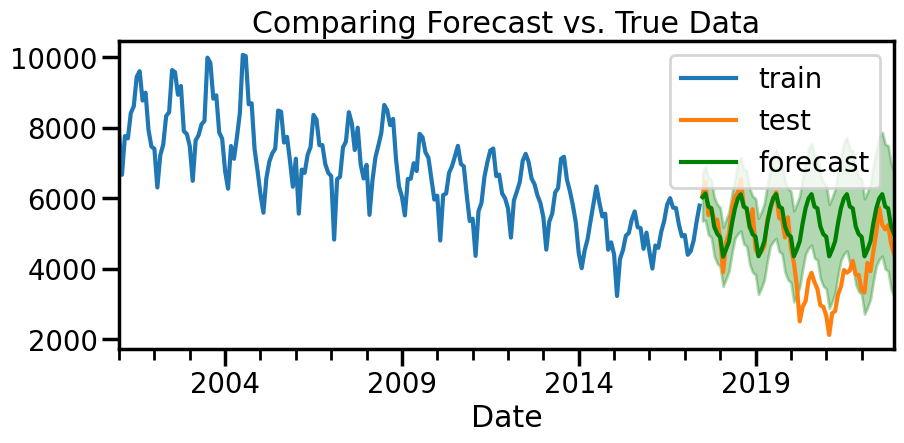

In [28]:
# Obtain summary of forecast as dataframe
forecast_df = sarima.get_forecast(len(test_t)).summary_frame()
# Plot the forecast with true values
plot_forecast(train_t, test_t, forecast_df)
# Obtain metrics
regression_metrics_ts(test_t, forecast_df["mean"])

In [29]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             THEFT   No. Observations:                  198
Model:             ARIMA(1, 0, 1)x(1, 1, [], 12)   Log Likelihood               -1360.840
Date:                           Sat, 28 Oct 2023   AIC                           2729.680
Time:                                   09:38:22   BIC                           2742.583
Sample:                               01-31-2001   HQIC                          2734.909
                                    - 06-30-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7045      0.040     17.653      0.000       0.626       0.783
ma.L1         -0.1777      0.103     -1.733      0.083      -0.379       0.023
ar.S.L12      -0.2045      0.053     -3.880      0.000      -0.308      -0.101
sigma2      1.189e+05   1.13e+04     10.558      0.000    9.68e+04    1.41e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):                15.93
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                            -0.19
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

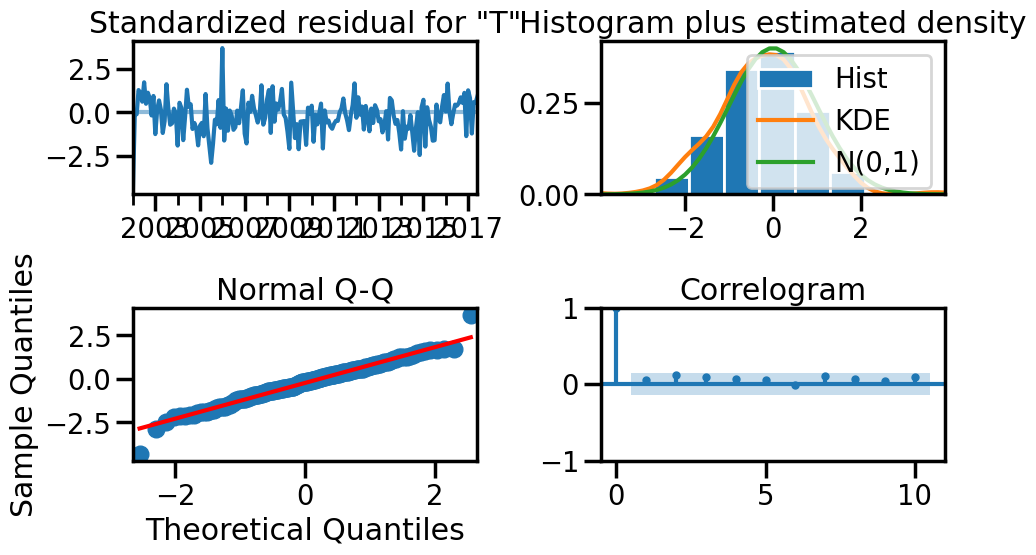

In [30]:
# Obtain diagnostic plots
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

In [31]:
# Define the value or range of values for p, d, q
p_values = range(0, 3)  
d_values = [1]          
q_values = range(0, 3)  
P_values = range (0, 3)
D_values = [0]
Q_values = range (0,3)
m = [12]

# Create combinations of pdq to test
pdqPDQm_to_try = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, m))

# Display first 10 combinations
pdqPDQm_to_try[:10]

[(0, 1, 0, 0, 0, 0, 12),
 (0, 1, 0, 0, 0, 1, 12),
 (0, 1, 0, 0, 0, 2, 12),
 (0, 1, 0, 1, 0, 0, 12),
 (0, 1, 0, 1, 0, 1, 12),
 (0, 1, 0, 1, 0, 2, 12),
 (0, 1, 0, 2, 0, 0, 12),
 (0, 1, 0, 2, 0, 1, 12),
 (0, 1, 0, 2, 0, 2, 12),
 (0, 1, 1, 0, 0, 0, 12)]

In [32]:
# define starting aic as infinity
best_aic = float("inf")  

# define baseline for pdq
best_pdqPDQm = (0,0,0,0,0,0,0)

# Loop through each combination
for pdqPDQm in pdqPDQm_to_try:
    order = pdqPDQm[:3] # first three values are non seasonal (p,d,q)
    seasonal_order = pdqPDQm[3:] # Remaining values for seasonal (P,D,Q,m)
    
    model = tsa.ARIMA(train_t, order=order, seasonal_order = seasonal_order)
    try:                         
        result = model.fit()
        print(pdqPDQm, result.aic)      
   
    except:
        print(f'{pdqPDQm}: caused an error')
    
    # If lower, replace best AIC with new value
    if result.aic < best_aic:
        
        best_aic = result.aic
        best_pdqPDQm = pdqPDQm

# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdqPDQm:", best_pdqPDQm)

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge

(0, 1, 0, 0, 0, 0, 12) 3126.0719394733023
(0, 1, 0, 0, 0, 1, 12) 3017.639360869397
(0, 1, 0, 0, 0, 2, 12) 2975.2738119452815


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge

(0, 1, 0, 1, 0, 0, 12) 2911.245198717519
(0, 1, 0, 1, 0, 1, 12) 2877.699865617329
(0, 1, 0, 1, 0, 2, 12) 2877.1164271604844
(0, 1, 0, 2, 0, 0, 12) 2896.8327754430284


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge

(0, 1, 0, 2, 0, 1, 12) 2877.5991134461337


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(0, 1, 0, 2, 0, 2, 12) 2878.518944471816
(0, 1, 1, 0, 0, 0, 12) 3126.749748373579
(0, 1, 1, 0, 0, 1, 12) 3015.3786982982992


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge

(0, 1, 1, 0, 0, 2, 12) 2970.6634163446342
(0, 1, 1, 1, 0, 0, 12) 2892.871668711462
(0, 1, 1, 1, 0, 1, 12) 2856.624661275183


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge

(0, 1, 1, 1, 0, 2, 12) 2855.8917739002263
(0, 1, 1, 2, 0, 0, 12) 2876.530836817702


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge

(0, 1, 1, 2, 0, 1, 12) 2856.399905811306


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(0, 1, 1, 2, 0, 2, 12) 2959.765656808723
(0, 1, 2, 0, 0, 0, 12) 3111.2256273815356
(0, 1, 2, 0, 0, 1, 12) 3010.4451016398234


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge

(0, 1, 2, 0, 0, 2, 12) 2968.1995316971934
(0, 1, 2, 1, 0, 0, 12) 2894.204367208514


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge

(0, 1, 2, 1, 0, 1, 12) 2857.534987736562


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(0, 1, 2, 1, 0, 2, 12) 2856.648023056323
(0, 1, 2, 2, 0, 0, 12) 2878.049967515601


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge

(0, 1, 2, 2, 0, 1, 12): caused an error


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebre

(0, 1, 2, 2, 0, 2, 12) 2883.8619516768526
(1, 1, 0, 0, 0, 0, 12) 3126.1841863418585
(1, 1, 0, 0, 0, 1, 12) 3014.3388734115288
(1, 1, 0, 0, 0, 2, 12) 2969.4226523819916
(1, 1, 0, 1, 0, 0, 12) 2895.3608249991607


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge

(1, 1, 0, 1, 0, 1, 12) 2859.9529496795567


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(1, 1, 0, 1, 0, 2, 12) 2859.465994955206
(1, 1, 0, 2, 0, 0, 12) 2878.90609958783


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge

(1, 1, 0, 2, 0, 1, 12) 2899.284568074573


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(1, 1, 0, 2, 0, 2, 12) 2882.0816733410807
(1, 1, 1, 0, 0, 0, 12) 3125.9860839851685
(1, 1, 1, 0, 0, 1, 12) 3015.4832177840262


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge

(1, 1, 1, 0, 0, 2, 12) 2977.173539289315
(1, 1, 1, 1, 0, 0, 12) 2885.7991058945863


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebre

(1, 1, 1, 1, 0, 1, 12) 2881.570325659464
(1, 1, 1, 1, 0, 2, 12) 2889.1857565688406


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebre

(1, 1, 1, 2, 0, 0, 12) 2874.719624143433
(1, 1, 1, 2, 0, 1, 12): caused an error


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebre

(1, 1, 1, 2, 0, 2, 12) 2917.178162994986
(1, 1, 2, 0, 0, 0, 12) 3105.1716449756686
(1, 1, 2, 0, 0, 1, 12) 3019.365360881915


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebre

(1, 1, 2, 0, 0, 2, 12) 2973.5566148430407
(1, 1, 2, 1, 0, 0, 12) 2969.9632976196267


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(1, 1, 2, 1, 0, 1, 12) 2914.7942910665047
(1, 1, 2, 1, 0, 2, 12): caused an error


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(1, 1, 2, 2, 0, 0, 12) 2880.5060226185938


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(1, 1, 2, 2, 0, 1, 12) 2985.8116414462165


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(1, 1, 2, 2, 0, 2, 12) 2978.964522284763
(2, 1, 0, 0, 0, 0, 12) 3118.6673900873734
(2, 1, 0, 0, 0, 1, 12) 3014.0347855938044


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge

(2, 1, 0, 0, 0, 2, 12) 2970.1384959520583
(2, 1, 0, 1, 0, 0, 12) 2895.408652684572


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge

(2, 1, 0, 1, 0, 1, 12) 2859.883413106292


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebre

(2, 1, 0, 1, 0, 2, 12) 2866.9892619922366
(2, 1, 0, 2, 0, 0, 12) 2879.446331352433


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(2, 1, 0, 2, 0, 1, 12) 2899.460298851626


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebre

(2, 1, 0, 2, 0, 2, 12) 2883.6142585437333
(2, 1, 1, 0, 0, 0, 12) 3120.188433484336


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(2, 1, 1, 0, 0, 1, 12) 3016.07204679566
(2, 1, 1, 0, 0, 2, 12) 2971.9809319857513


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(2, 1, 1, 1, 0, 0, 12) 2899.334663387356


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebre

(2, 1, 1, 1, 0, 1, 12) 2871.1532634997984
(2, 1, 1, 1, 0, 2, 12) 2954.7941161461376


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebre

(2, 1, 1, 2, 0, 0, 12) 2883.2678054454


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


(2, 1, 1, 2, 0, 1, 12) 2872.5830503509906
(2, 1, 1, 2, 0, 2, 12): caused an error
(2, 1, 2, 0, 0, 0, 12) 3098.369440281339


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressiv

(2, 1, 2, 0, 0, 1, 12) 3005.9997836128578


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebre

(2, 1, 2, 0, 0, 2, 12) 2977.7987720830433


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebre

(2, 1, 2, 1, 0, 0, 12) 2917.4428007696824
(2, 1, 2, 1, 0, 1, 12): caused an error


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebre

(2, 1, 2, 1, 0, 2, 12) 2861.6861404402116


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebre

(2, 1, 2, 2, 0, 0, 12) 2886.2086271626495


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebre

(2, 1, 2, 2, 0, 1, 12) 16.0
(2, 1, 2, 2, 0, 2, 12) 2891.6006503443323
Best AIC: 16.0
Best pdqPDQm: (2, 1, 2, 2, 0, 1, 12)


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [33]:
# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train_t,
    seasonal=True,  
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3128.021, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2897.221, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3017.290, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3126.072, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3128.148, Time=0.01 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2861.530, Time=0.21 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3016.273, Time=0.07 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=2861.008, Time=0.45 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=2971.360, Time=0.26 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=2878.434, Time=0.41 sec
 ARIMA(2,1,0)(1,0,2)[12] intercept   : 

In [34]:
# Orders for non seasonal components
p = 2 # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0  # nonseasonal MA
# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 2  # Seasonal MA
m = 12 # Seasonal period
sarima = tsa.ARIMA(train_t, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 734.597
- MSE = 1,130,821.905
- RMSE = 1,063.401
- R^2 = 0.068
- MAPE = 21.02%


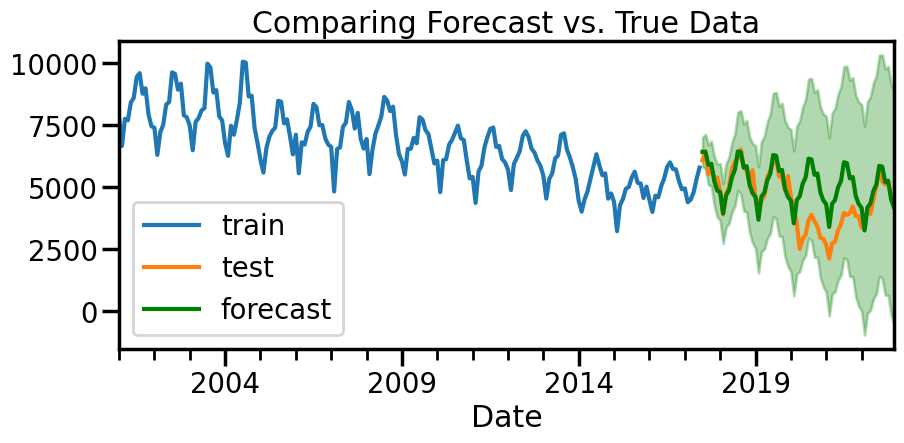

In [35]:
# Obtain summary of forecast as dataframe
forecast_df = sarima.get_forecast(len(test_t)).summary_frame()
# Plot the forecast with true values
plot_forecast(train_t, test_t, forecast_df)
# Obtain metrics
regression_metrics_ts(test_t, forecast_df["mean"])

###  **Model Choice**_Theft
###  Best model:
 - ARIMA(2,1,0)(1,0,2)[12]
 
 Regression Metrics: 
-------------
- MAE = 734.597
- MSE = 1,130,821.905
- RMSE = 1,063.401
- R^2 = 0.068
- MAPE = 21.02%
---------
-------
###  Original Model:
* ARIMA(1,0,1)(1,1,0)
Regression Metrics: 
-------------
- MAE = 906.173
- MSE = 1,548,134.924
- RMSE = 1,244.241
- R^2 = -0.275
- MAPE = 26.11%

**We will choose the Best fit Model.**

### Battery

In [ ]:
ts_b = unstacked['BATTERY']
ax = ts_b.plot()

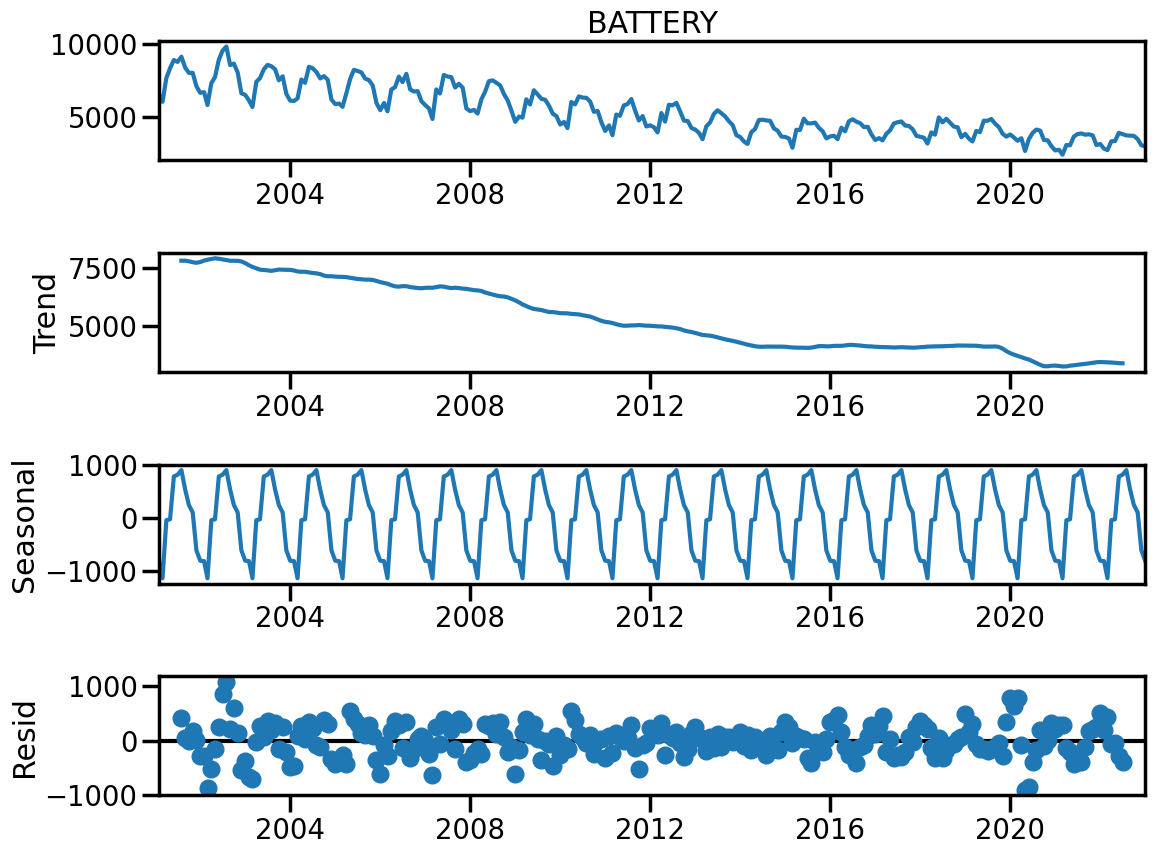

In [37]:
# Apply seasonal decompose
decomp_b = tsa.seasonal_decompose(ts_b)
fig = decomp_b.plot()
fig.set_size_inches(12,9)
fig.tight_layout()

In [38]:
# Measure seasonal component
seasonal_delta_b = decomp_b.seasonal.max() - decomp_b.seasonal.min()
# Measure seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta_b} which is ~{seasonal_delta_b/float(ts_b.max()-ts_b.min()) * 100 :.2f}% of the variation in time series.")

The seasonal component is 2040.128968253968 which is ~27.70% of the variation in time series.


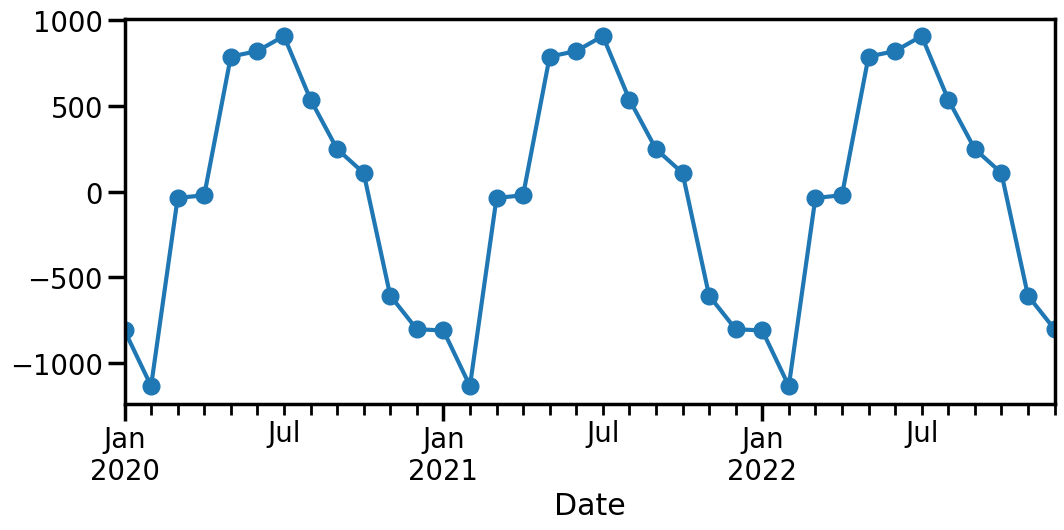

In [60]:
# Narrow down the date range of the plot
seasonal_b = decomp_b.seasonal
ax = seasonal_b.loc['2020': ].plot(marker = 'o')

In [40]:
# determine d
d = ndiffs(ts_b)
print (f'd = {d}')

d = 1


In [41]:
# Determine D
D = nsdiffs(ts_b, m =12)
print(f'D = {D}')

D = 0


In [42]:
# Difference the data
ts_diff_b = ts_b.diff().dropna()

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


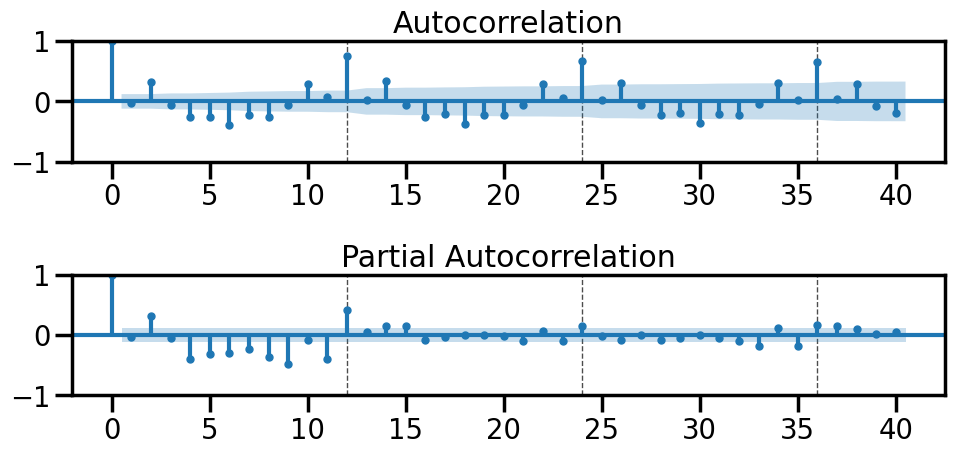

In [43]:
# Use function to highlight the seasonal lags by adding the arguments
plot_acf_pacf(ts_diff_b, annotate_seas=True, m = 12, method = 'ywm');

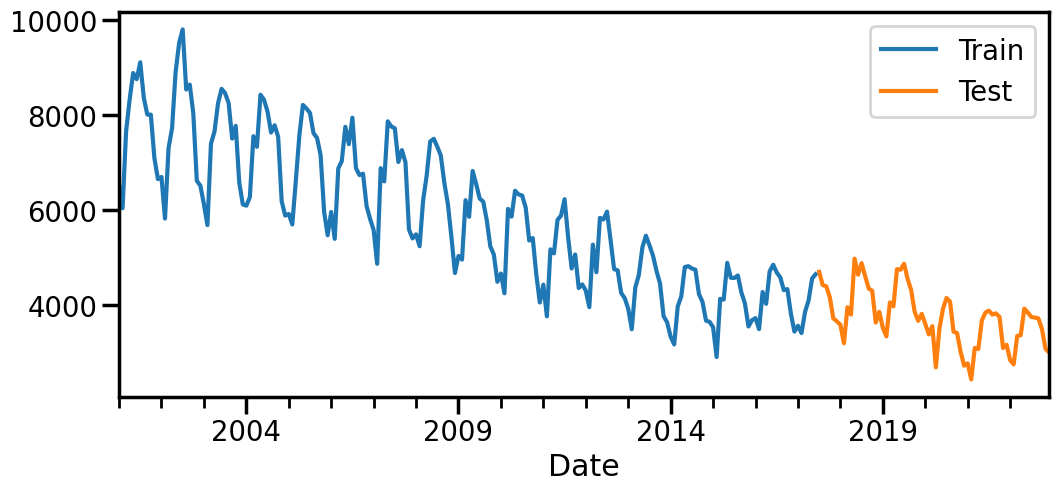

In [63]:
train_b, test_b = train_test_split(ts_b, test_size=.25)
ax = train_b.plot(label='Train')
test_b.plot(ax=ax, label='Test')
ax.legend();

In [64]:
# Orders for non seasonal components
p = 1 # nonseasonal AR
d = 0  # nonseasonal differencing
q = 1  # nonseasonal MA
# Orders for seasonal components
P = 1  # Seasonal AR
D = 1  # Seasonal differencing
Q = 0  # Seasonal MA
m = 12 # Seasonal period
sarima = tsa.ARIMA(train_b, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 436.759
- MSE = 305,426.219
- RMSE = 552.654
- R^2 = 0.124
- MAPE = 12.84%


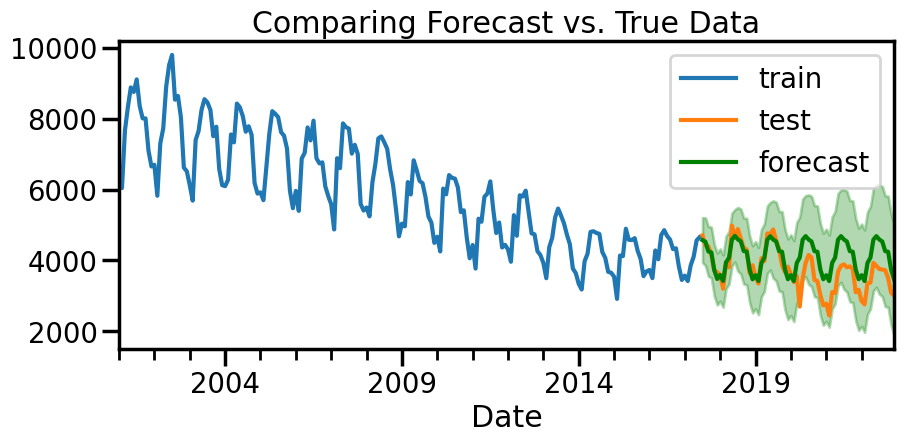

In [65]:
# Obtain summary of forecast as dataframe
forecast_df = sarima.get_forecast(len(test_b)).summary_frame()
# Plot the forecast with true values
plot_forecast(train_b, test_b, forecast_df)
# Obtain metrics
regression_metrics_ts(test_b, forecast_df["mean"])

In [66]:
# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train_b,
    seasonal=True,  
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3095.173, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2900.013, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2990.934, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3093.222, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3097.019, Time=0.01 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2848.567, Time=0.18 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2989.668, Time=0.08 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=2850.655, Time=0.70 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=2850.560, Time=0.60 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=2967.966, Time=0.33 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.76 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2869.767, Time=0.17 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,1,1)(1,0,1)[12]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/pmdarima/arima/arima.py", line 597, in fit
    self._fit(y, X, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/pmdarima/arima/arima.py", line 518, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/pmdarima/arima/arima.py", line 508, in _fit_wrapper
    return arima, arima.fit(

 ARIMA(1,1,1)(1,0,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(3,1,1)(1,0,1)[12]             : AIC=inf, Time=0.40 sec

Best model:  ARIMA(2,1,0)(1,0,1)[12]          
Total fit time: 15.612 seconds


In [71]:
# Orders for non seasonal components
p = 3 # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1  # nonseasonal MA
# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period
sarima = tsa.ARIMA(train_b, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 287.511
- MSE = 121,298.599
- RMSE = 348.279
- R^2 = 0.652
- MAPE = 7.78%


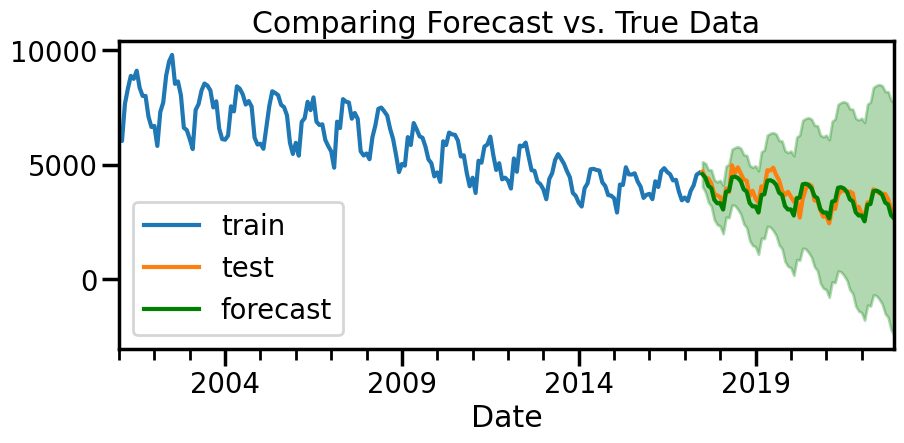

In [72]:
# Obtain summary of forecast as dataframe
forecast_df = sarima.get_forecast(len(test_b)).summary_frame()
# Plot the forecast with true values
plot_forecast(train_b, test_b, forecast_df)
# Obtain metrics
regression_metrics_ts(test_b, forecast_df["mean"])

###  **Model Choice**_ Battery
### Best Model:
 - ARIMA(3,1,1)(1,0,1)[12]
 
Regression Metrics: 
----------------------------
- MAE = 287.511
- MSE = 121,298.599
- RMSE = 348.279
- R^2 = 0.652
- MAPE = 7.78%
---------
---------
###  Original Model:
- ARIMA((1,0,1)(1,1,0)[12}

Regression Metrics: 
----------
- MAE = 436.759
- MSE = 305,426.219
- RMSE = 552.654
- R^2 = 0.124
- MAPE = 12.84%


**WE will, again Chose the best fit model.**

In [73]:
len(test_t)

66

In [76]:
# Final model
# Orders for non seasonal components
p = 2  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 2  # Seasonal MA
m = 12 # Seasonal period

final_model_t = tsa.ARIMA(ts_t, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


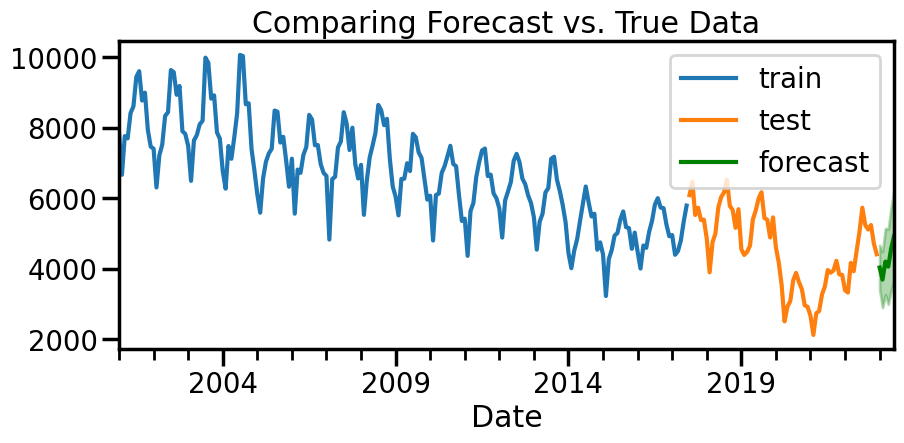

In [80]:
forecast_df_t  = final_model_t.get_forecast(6).summary_frame()
plot_forecast(train_t,test_t,forecast_df_t);

In [79]:
forecast_df_t.index[0],forecast_df_t.index[-1]

(Timestamp('2023-01-31 00:00:00', freq='M'),
 Timestamp('2023-06-30 00:00:00', freq='M'))

In [87]:
starting_value_t = forecast_df_t['mean'].iloc[0]
starting_value_t

4035.153878546234

In [88]:
final_value_t = forecast_df_t['mean'].iloc[-1]
final_value_t

4931.3854879626215

In [89]:
change_t = final_value_t - starting_value_t
change_t

896.2316094163875

In [90]:
perc_change_t = (change_t / starting_value_t) * 100
perc_change_t

22.210593112232875

##  Change Theft
* The total Predicted increase in *Theft* over the six month period after the data set is:
   - Raw Increase = ~896
   - Percentage change = ~22.2%

In [81]:
len(test_b)

66

In [83]:
# Final model/Battery
# Orders for non seasonal components
p = 3  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

final_model_b = tsa.ARIMA(ts_b, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


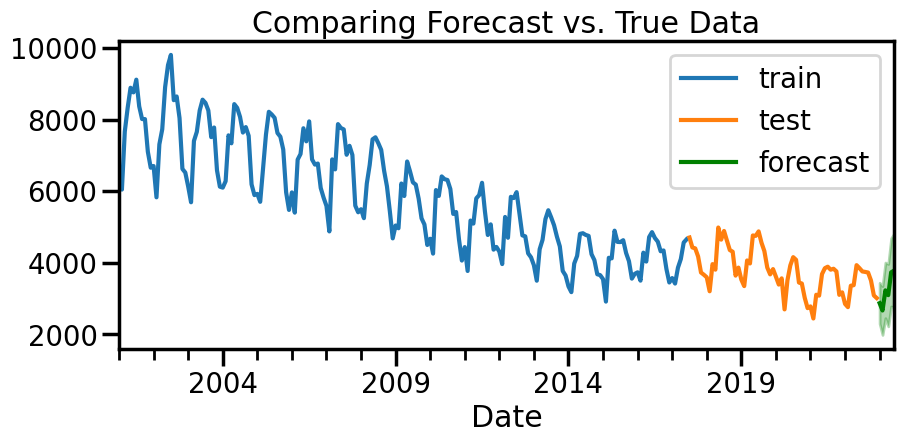

In [85]:
forecast_df_b  = final_model_b.get_forecast(6).summary_frame()
plot_forecast(train_b,test_b,forecast_df_b);

In [86]:
forecast_df_b.index[0],forecast_df_b.index[-1]

(Timestamp('2023-01-31 00:00:00', freq='M'),
 Timestamp('2023-06-30 00:00:00', freq='M'))

In [91]:
starting_value_b = forecast_df_b['mean'].iloc[0]
starting_value_b

2866.337747169798

In [92]:
final_value_b = forecast_df_b['mean'].iloc[-1]
final_value_b

3776.849210988124

In [93]:
change_b = final_value_b - starting_value_b
change_b

910.5114638183259

In [94]:
perc_change_b = (change_b / starting_value_b) * 100
perc_change_b

31.765672580537952

##  Change Battery
* The predicted increase in *Battery*:
  - Raw increase = 910.5
  - Percentage increase = ~31.76%

In [95]:
crime_tb = ['THEFT','BATTERY']
plot_df = df_ts.loc[crime_tb].copy()
plot_df


Primary Type  Date      
THEFT         2001-01-31    7867
              2001-02-28    6669
              2001-03-31    7766
              2001-04-30    7702
              2001-05-31    8420
                            ... 
BATTERY       2022-08-31    3740
              2022-09-30    3723
              2022-10-31    3501
              2022-11-30    3083
              2022-12-31    3009
Length: 528, dtype: int64

In [49]:
plot_df.isna().sum()

0

In [50]:
unstacked = plot_df.unstack(level=0)
unstacked

Primary Type,THEFT,BATTERY
Date,,
2001-01-31,7867,6527
2001-02-28,6669,6042
2001-03-31,7766,7662
2001-04-30,7702,8328
2001-05-31,8420,8887
...,...,...
2022-08-31,5244,3740
2022-09-30,5117,3723
2022-10-31,5242,3501


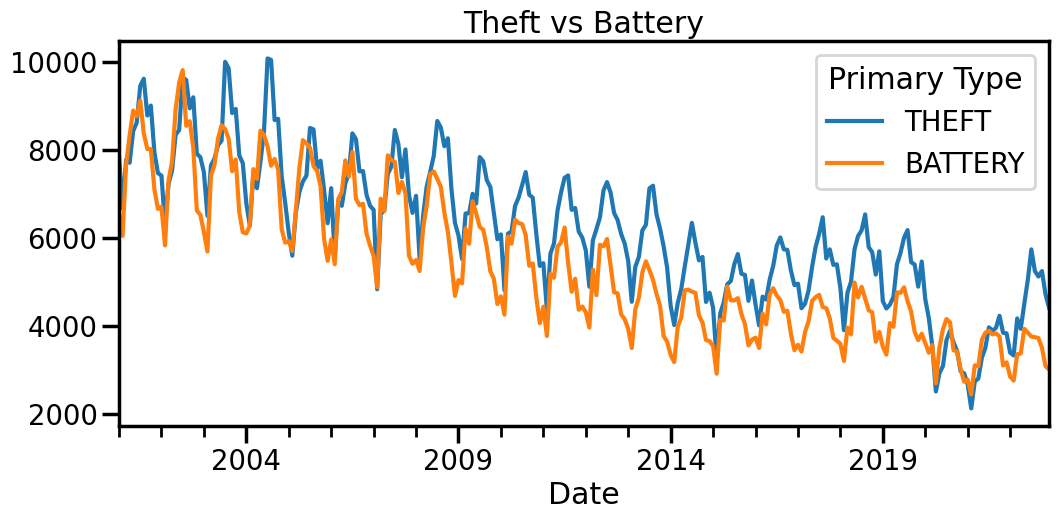

In [100]:
ax = unstacked.plot(title='Theft vs Battery')                     

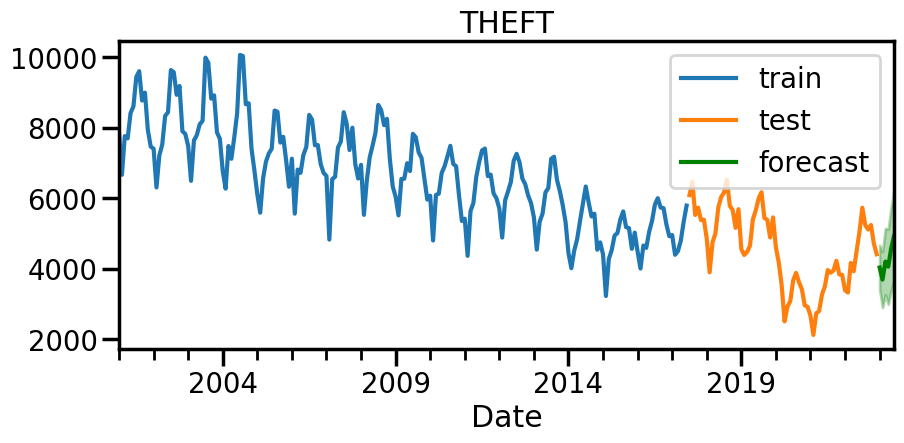

In [103]:
forecast_df_t  = final_model_t.get_forecast(6).summary_frame()
ax = plot_forecast(train_t,test_t,forecast_df_t, title = "THEFT");

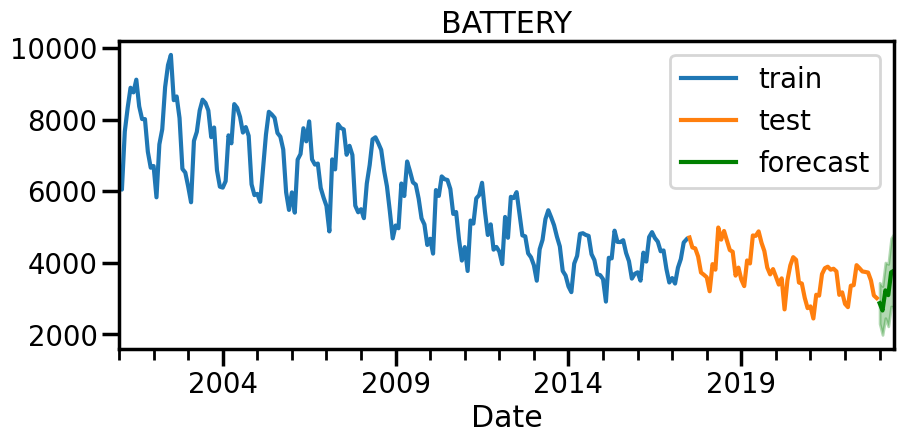

In [104]:
forecast_df_b  = final_model_b.get_forecast(6).summary_frame()
ax = plot_forecast(train_b,test_b,forecast_df_b, title = "BATTERY");

##  Final Recommendation:
* Although *Battery* and *Theft* are both Predicted to rise by Nearly 900 cases each.
  - *Battery* is predicted to see the higher Percentage increase (31.7%, to 22.2%).
     - **Therefore I would Recommend focusing resources on Battery preventivie measures.**